In [1]:
import syndat

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# create test df with continuous, categorical, and date/time vars
n = 10000
x_norm = np.random.randn(n)
x_unif = np.random.rand(n)
x_categ = np.random.choice(['c1','c2','c3'], size=n, p=[0.2,0.3,0.5])
x_date = np.random.permutation(
    pd.date_range('2000-01-01', '2020-01-01', periods=n)
)

df = pd.DataFrame(
    {'x_norm':x_norm, 'x_unif':x_unif, 'x_categ':x_categ, 'x_date':x_date}
)

# convert dt to str to make the data more realistic
df['x_date'] = df['x_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df.head()

,x_norm,x_unif,x_categ,x_date
0,0.096784,0.521931,c3,2018-04-02
1,-0.207274,0.270695,c3,2017-06-01
2,-1.339956,0.922621,c3,2019-07-16
3,0.791830,0.714639,c3,2000-10-09
4,0.960873,0.898352,c1,2013-12-29


In [4]:
# inject NAs
n_na = int(len(df)/100)
for c in df.columns:
    df.loc[np.random.choice(np.arange(len(df)), n_na), c] = np.nan
df.isnull().sum()

x_norm      98
x_unif     100
x_categ     99
x_date      99
dtype: int64

In [ ]:
cols = {'x_norm':'float', 'x_unif':'float', 'x_categ':'unord', 'x_date':'dt'}
# allowed types: quant, categ, ord, dt

# Synthetic data generation

In [ ]:
# dt na encoding
import dt_null_encoder

df_orig = df.copy() # need df_orig for decoding dt nulls
df = dt_null_encoder.encode(df, cols)

## Multivariate density estimation and sampling

In [50]:
# the multivariate approach cannot hadnle NAs in int and float columns.
# impute NAs before calling syndat
df_imp = df.copy()

# replace NAs with 0 for now - can do "better", e.g., replace with median
df_imp[['x_norm','x_unif']] = df_imp[['x_norm','x_unif']] .fillna(0)

df_imp.isnull().sum()

x_norm      0
x_unif      0
x_categ    99
x_date      0
dtype: int64

In [ ]:
sd = syndat.SynDat(df_imp, cols, convert_dt=True)

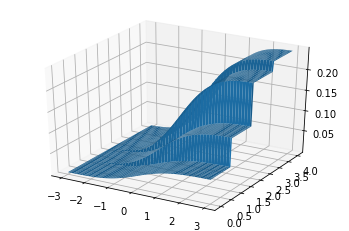

In [52]:
# plot mixture of continuous and categorical - CDF
x=np.linspace(-3,3,100)
y=np.linspace(0,4,100)
X, Y = np.meshgrid(x,y)
x_unif_samp = 0.5
x_date_samp = np.median(sd.df['x_date'])
z = np.array([sd.kde.cdf([x,x_unif_samp,y,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

Note that the fourth category corresponds to NAs

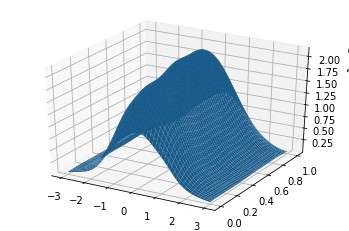

In [53]:
# plot continuous vars - PDF
x=np.linspace(-3,3,100)
y=np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)

x_categ_samp = 2
x_date_samp = np.median(sd.df['x_date'])
z = np.array([sd.kde.pdf([x,y,x_categ_samp,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

In [54]:
# get synthetic data
df_samp = sd.get_sample(n=1000)

M = 2.117946805328612e-05


In [55]:
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.427827,0.240209,c2,2012-09-14
1,-0.631784,0.378779,c3,2019-05-24
2,0.255827,0.806689,c3,2015-05-06
3,0.044252,0.447423,c2,1993-11-13
4,-1.266632,0.400447,c3,2010-10-06


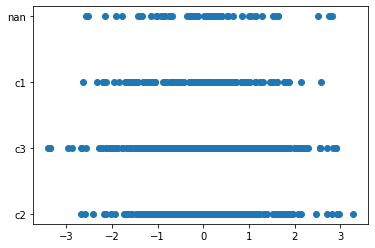

In [56]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

Note the addition of the nan category. If desired, NAs can be imputed before calling syndat

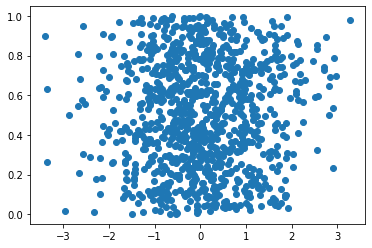

In [57]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])

In [ ]:
# save data to files
import json
df.to_csv('samp_dat.csv', index=False)

with open('samp_cols.json', 'w') as fid:
    json.dump(cols, fid)


## Univariate density estimation and sampling

In [58]:
# unlike the multivariate approach, the univariate approach
# does not break if there are NAs in int and float cols
df.isnull().sum()

x_norm     100
x_unif      99
x_categ     99
x_date       0
dtype: int64

In [59]:
sd = syndat.SynDat(df, cols, convert_dt=True, independent_cols=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


In [60]:
df_samp = sd.get_sample(n=1000)
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.485593,0.038311,c3,2000-07-22
1,-0.940923,0.981730,c2,2010-01-26
2,0.487461,0.488803,c3,2017-10-15
3,-0.319981,0.980402,c1,2003-10-28
4,1.081734,0.024650,c3,2013-11-20


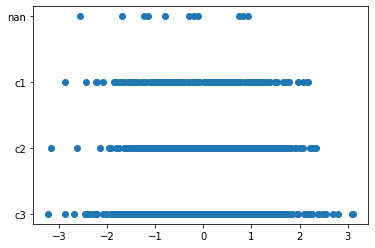

In [61]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

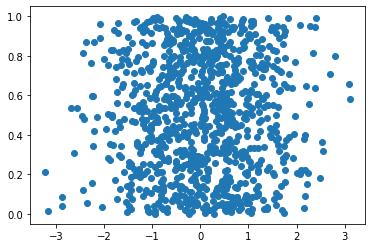

In [62]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])

# Encoding categorical variables (e.g., for masking the real data)

In [63]:
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.485593,0.038311,c3,2000-07-22
1,-0.940923,0.981730,c2,2010-01-26
2,0.487461,0.488803,c3,2017-10-15
3,-0.319981,0.980402,c1,2003-10-28
4,1.081734,0.024650,c3,2013-11-20


In [64]:
import label_encoder

le_dict = {
    'categ': ['x_categ']
}

le = label_encoder.LabelEncoder(le_dict, df_samp)
df_samp = le.encode(df_samp)
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.485593,0.038311,2,2000-07-22
1,-0.940923,0.981730,1,2010-01-26
2,0.487461,0.488803,2,2017-10-15
3,-0.319981,0.980402,0,2003-10-28
4,1.081734,0.024650,2,2013-11-20
